### 0. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import plot_across_time, plot_length, plot_metrics_scores, expand_contractions, remove_words, preprocess_quote, \
    generate_speaker_affiliations, save_pickle, join_quotes_with_speaker_affiliations, read_most_common, create_and_save_model_topic_clusterer
from tqdm import tqdm
from scipy.stats import ttest_ind
from datetime import datetime
from constants import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import download
from nltk.corpus import stopwords
download('stopwords', quiet=True)
download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from scipy.stats import ttest_ind
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from torch import cuda
from roberta import Roberta
import statsmodels.api as sm
from scipy import stats

sns.set()

### 1. Preprocessing
#### Getting politicians dataset
To obtain a dataset of politicians' quotations, we need to enrich the original *Quotebank* dataset with additional information about the speakers' political affiliations. To achieve that, we propose a preprocessing pipeline.

First, load the *Wikidata* table from the `.parquet` file (provided on the *Quotebank*'s Google Drive). Keep the columns containing information interesting for us - speaker's QID and label, and party's QID, discard the others and drop the rows with missing values. Convert that to a `pandas DataFrame` and dump it into a `.pickle` file. 

Then, for each of the years load the initial *Quotebank* data. The initial dataset is represented as a list of `json` objects - process it into a `DataFrame` in a line-by-line manner, only keeping the quotation content and QID, as well as the speaker's QID. Dump the dataframe into a `.pickle` file.

Next, perform an inner join between the two dataframes on the speaker QID - that way you end up with a dataframe containing quotations, along with information about the speaker's political affiliation.

The *Quotebank* dataset is divided into batches based on the quotation date - 6 files are corresponding to years from 2015 until 2020. Therefore we perform the pipeline explained above 6 times, and then merge the results into a single dataframe. We end up with a dataset of around 17m quotations.

In [3]:
print("Generating speaker affiliations DF...")
if not os.path.exists(SPEAKER_AFFILIATIONS_OUT_PATH):
    generate_speaker_affiliations(PARQUET_PATH, SPEAKER_AFFILIATIONS_OUT_PATH)

print("Done.\n")

Generating speaker affiliations DF...
Done.



In [4]:

# dataset loading - perform for each batch of the data (2015, 2016, ..., 2019)
years = [i for i in range(2015, 2020)]
for year in years:
    DATASET_PATH_JSON_BZ2 = f"data/raw/quotes-{year}.json.bz2"
    DATASET_PATH_PICKLE = f"data/binary/data-{year}.pickle"
    MERGED_OUT_PATH = f"data/binary/data-{year}.pickle"

    print("Generating quotes DF...")
    if not os.path.exists(DATASET_PATH_PICKLE):
        save_pickle(DATASET_PATH_JSON_BZ2, DATASET_PATH_PICKLE)
    print("Done.\n")

    df_quotes = pd.read_pickle(DATASET_PATH_PICKLE)
    df_affiliations = pd.read_pickle(SPEAKER_AFFILIATIONS_OUT_PATH)

    print("Generating merged df...")
    if not os.path.exists(MERGED_OUT_PATH):
        join_quotes_with_speaker_affiliations(
            df_quotes, df_affiliations, MERGED_OUT_PATH)
    print(year, "Done.\n")


Generating quotes DF...
Done.

Generating merged df...
2015 Done.

Generating quotes DF...
Done.

Generating merged df...
2016 Done.

Generating quotes DF...
Done.

Generating merged df...
2017 Done.

Generating quotes DF...
Done.

Generating merged df...
2018 Done.

Generating quotes DF...
Done.

Generating merged df...
2019 Done.



In [5]:
# merge the results for the separate years into a single dataframe,
# and extracting date from the quote_id and saving it into a new column as datetime.
# Save all into a pickle named data.pickle

if not os.path.exists(US_POLITICIANS):
    years = [2015, 2016, 2017, 2018, 2019]
    paths = [f"data/binary/data-{year}.pickle" for year in years]
    dfs = [pd.read_pickle(path) for path in paths]
    merged_df = pd.concat(dfs, ignore_index=True)
    # create an additional datetime column - useful for temporal analysis
    merged_df["Date-Time"] = pd.to_datetime(merged_df['quote_id'].apply(
        lambda x: datetime.strptime(x[:10], '%Y-%m-%d')))
    merged_df.to_pickle(US_POLITICIANS)

#### US Politicians dataset
To obtain a dataset of US Politician quotations, we proceed to:
1. Only keep the quotations where the speaker's party is `29468` (Republican party) or `29552` (Democratic party).
2. Filter out the rows that have `None` as a value in the `Candidacy` column in the Wikidata - the majority of the speakers affiliated with the political parties were not actual politicians - they are often celebrities, sports stars, TV personalities, etc. We believe it is beneficial to only take the actual politicians, as they are more likely to speak about actual political matters and represent their party's ideology.

Performing step 1 reduces the size of the dataset from 17 million rows to around 8 million rows, and step 2 reduces the size further to around 1.6 million.

In [6]:
# additional preprocessing to obtain the US politicans data
data = pd.read_pickle(US_POLITICIANS)
# filter to only keep the american politicians
data = data[data["party"].isin([DEMOCRATIC_PARTY_ID, REPUBLICAN_PARTY_ID])]

In [7]:
# maintain only the quotes where the speakers are actually politicians - they were candidates in at least one election
speaker_data = pd.read_parquet(PARQUET_PATH)
candidates = speaker_data[["id", "candidacy"]]
candidates = candidates.dropna()
candidates = candidates.drop(columns=["candidacy"])
candidates["id"] = candidates["id"].apply(lambda x: int(x[1:]))
candidates.head()

,id
0,23
3,207
11,815
15,946
18,1058


In [8]:
# use candidacy info to filter down the speakers.
data = pd.merge(left=data, left_on="speaker_id",
                right_on="id", right=candidates)
data = data.drop(columns=["id"])
data.head()

,speaker_id,quote_id,quotation,speaker,party,Date-Time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09


In [9]:
# save to pickle
if not os.path.exists(US_POLITICIANS):
    data.to_pickle(US_POLITICIANS)

### 2. Topic clustering

In this section we'll try to divide the quotes into clusters of different topics. First, let's see which are the most common words used by politicians.

In [10]:
# load the stopwords (extend the standard list by the contraction leftovers)
stopwords = stopwords.words('english') + ['nt', 'ca', 'wo']
print("Example stopwords: ", stopwords[:10])

# load the data
data = pd.read_pickle(US_POLITICIANS)
sample_df = data.sample(100000)

# expand contractions, remove stopwords, preprocess text
sample_df["quotation"] = sample_df["quotation"] \
    .apply(expand_contractions) \
    .apply(lambda quote: remove_words(quote, stopwords)) \
    .apply(preprocess_quote)

Example stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [11]:
def get_words(df):
    if isinstance(df, pd.DataFrame):
        quotes = df["quotation"]
    elif isinstance(df, pd.Series):
        quotes = df
    else:
        raise ValueError('input must be a Dataframe or Series')

    tokenized = quotes.apply(lambda quote: word_tokenize(quote))
    words = tokenized.explode()
    words = words.astype("str")
    return words

words = get_words(sample_df)
print("Most common words: ")
words.value_counts()[:10]

Most common words: 


people       11438
going         8740
would         7741
think         7080
know          6109
president     5991
us            5575
like          5420
one           5166
get           5110
Name: quotation, dtype: int64

As you can see above, the most common words are somewhat meaningless for understanding the topics that politicians talk about. They are just words that appear commonly in English language. To be able to draw conclusions from the frequency analysis, we remove the 1000 most common words from the quotations and repeat the analysis.

In [12]:
# load the list of most common english words, taken from: https://gist.github.com/deekayen/4148741
def read_most_common(path):
    most_common = []
    with open(path, "r") as file:
        for line in file.readlines():
            most_common.append(line.strip())
    return most_common

most_common = read_most_common('data/misc/most_common_words_1000.txt')
most_common[:12]

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was']

We make use of stemming to perform better filtering of the words. We first apply stemming to the list of common words, and then for each token in the quotations we check if the stemmed version of the token appears in the common words list. If it does, we discard this token.

In [13]:
def filter_words(words):
    stemmer = PorterStemmer()
    most_common_stemmed = [stemmer.stem(word) for word in most_common]
    stemmed_words = {x: stemmer.stem(x) for x in (words.unique())}

    # and filter out the words w
    filtered_words = [
        word for word in words if stemmed_words[word] not in most_common_stemmed]

    return filtered_words

filtered_words = filter_words(words)
# print most popular words after filtering
pd.Series(filtered_words).value_counts()[:20]

president    5991
trump        4358
american     2991
america      2746
today        1642
americans    1539
important    1528
security     1482
health       1352
public       1341
campaign     1317
donald       1267
political    1267
china        1254
congress     1249
democrats    1229
tax          1228
vote         1219
military     1215
election     1214
dtype: int64

The results are much more meaningful - we can see keywords typical for politcs, e.g. 'america', 'president' or 'administration'. Let's visualize the results by plotting three word clouds:
* one for all the speakers
* one for the Democratic speakers only
* one for the Republican speakers only

In [14]:
def divide_by_party(df):
    democratic_party = DEMOCRATIC_PARTY_ID
    republican_party = REPUBLICAN_PARTY_ID
    democrats = df[df["party"] == democratic_party]
    republicans = df[df["party"] == republican_party]
    all_speakers = df.copy()

    return all_speakers, democrats, republicans

def make_wordcloud(df):
    words = get_words(df)
    filtered_words = filter_words(words)

    plt.rcParams["figure.figsize"] = (10, 10)

    wordcloud = WordCloud(width=1000, height=1000, max_font_size=150,
                          max_words=100, background_color="white")
    wordcloud.generate(" ".join(filtered_words))

    return wordcloud

In [15]:
common, democrats, republicans = divide_by_party(sample_df)

common_wordcloud = make_wordcloud(common)
democrats_worldcloud = make_wordcloud(democrats)
republican_wordcloud = make_wordcloud(republicans)

<Figure size 720x720 with 0 Axes>

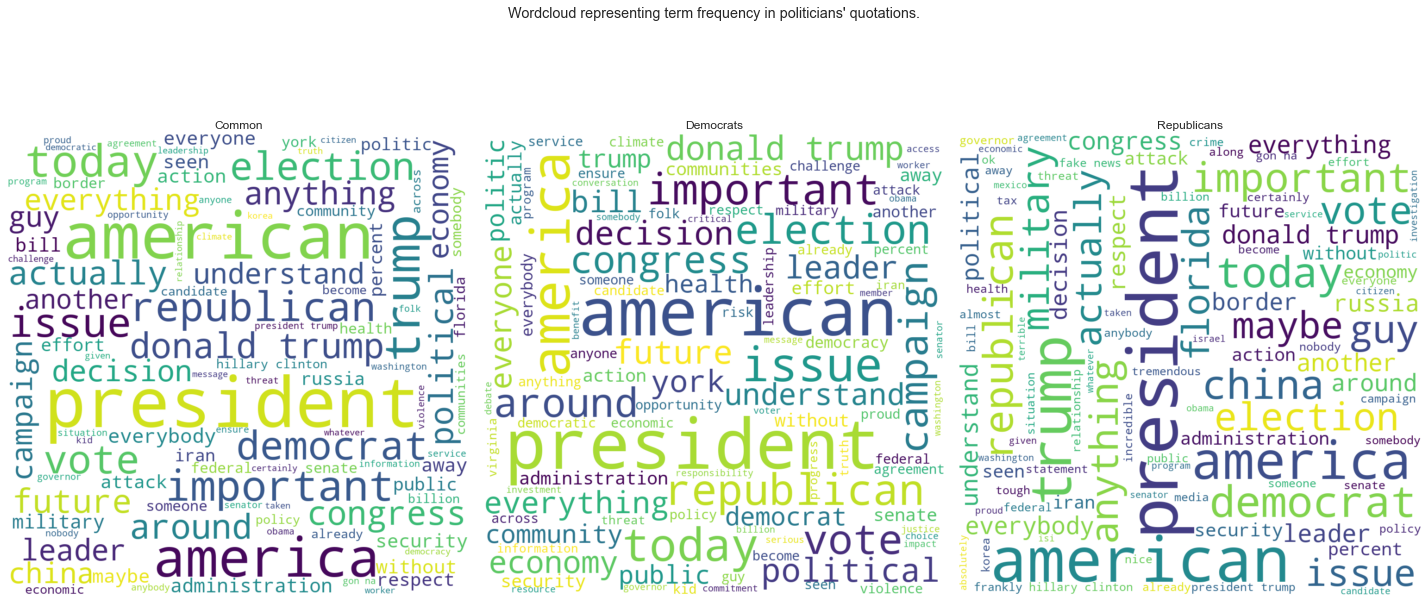

In [16]:
plt.figure()
fig, axs = plt.subplots(1, 3)
fig.suptitle(
    "Wordcloud representing term frequency in politicians' quotations.")

axs[0].set_title('Common')
axs[0].imshow(common_wordcloud, interpolation="bilinear")

axs[1].set_title('Democrats')
axs[1].imshow(democrats_worldcloud, interpolation="bilinear")

axs[2].set_title('Republicans')
axs[2].imshow(republican_wordcloud, interpolation="bilinear")

for ax in axs:
    ax.axis('off')

fig.set_size_inches(20, 10)
fig.tight_layout()
plt.show()

Identifying the most commonly used words is a good first step to understanding what do the politicians often talk about, but the results are a bit too fine-grained to draw meaningful conclusions from them.

To overcome this issue, we want to identify the high level concepts/topics that are commonly discussed, and classify each quote to one of the topics.

To achieve that, we first tried to use a transfer-learning approach: train a classifier on the data obtained from the [Manifesto-Project dataset](https://manifestoproject.wzb.eu), which provides sentences of the two parties' manifestos over years 2012, 2016, and 2020, labeled manually by experts to one of fifteen different topics/categories. Unfortunately, the data was too different from ours and thus the resulting accuracy was not satisfying. 

We then proceeded with unsupervised clustering using Bertopic, a topic modeling technique that leverages transformers
and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the
topic descriptions. After a quick manual preprocessing of the quotes and a preprocessing pipeline from Bertopic library
itself, we trained the model with a third of the dataset (0.6 million quotes), due to RAM limitations. Using that model we
then predicted topics for the whole dataset and saved the result in a new pickle.


In [17]:
do_training= False
if do_training:
    # Create Topic Model
    quotebank_path= "../data/binary/us-politicians.pickle"
    save_model_path = "../data/misc/BERTopic_model"
    save_pickle_path = "../data/binary/us-politicians-with-clusters"
    save_topics_txt_path= "../data/misc/topics.txt"
    create_and_save_model_topic_clusterer(quotebank_path, save_model_path, save_pickle_path, save_topics_txt_path)

Below you can see most popular words for some identified topics. For example, take a look at topic **539**,
which clearly corresponds to the concept of religion, or topic **611** which contains several keywords connected
to taxation.

In [18]:
import re

# Lets examine which are the most common words for each topic:
def read_topics(path):
    topics = {}
    with open(path, "r") as file:
        next(file)
        for line in file.readlines():
            split_line = (re.sub(r'[^A-Za-z0-9\' ]+', '', line)).split(' ')
            topic_num = split_line[1]
            topic_words = []
            for i in range(len(split_line)):
                word = split_line[i]
                if word[0] == "'":
                    if word[-1] != "'":
                        word += (" " + split_line[i+1])
                    topic_words.append(word[1:-1])
            topics[topic_num] = topic_words
    return topics


topics = read_topics("data/misc/topics.txt")
for num, words in topics.items():
    print(f"Topic {num} => {words}")


Topic 509 => ['don', 'christmas', 'didn', 'rudy', 'don don', 'haven', 'collusion', 'isn', 'seven', 'november']
Topic 71 => ['putin', 'witch', 'witch hunt', 'hunt', 'vladimir putin', 'hoax', '2016', 'isis', 'hack', '2016 election']
Topic 43 => ['iran', 'nuclear', 'iranian', 'nuclear weapon', 'nuclear weapons', 'saudi', 'iran nuclear', 'arabia', 'saudi arabia', 'nuclear program']
Topic 312 => ['black', 'racist', 'racism', 'racial', 'hatred', 'hate', 'african community', 'slavery', 'discrimination', 'sexist']
Topic 341 => ['farmers', 'coal', 'swamp', 'environmental', 'agriculture', 'rural', 'farm', 'clean energy', 'fishing', 'farmer']
Topic 335 => ['florida', 'puerto', 'hurricane', 'puerto rico', 'rico', 'floridians', 'coast', 'beach', 'miami', 'island']
Topic 539 => ['religion', 'christian', 'christians', 'bible', 'pray', 'worship', 'prayer', 'religious freedom', 'religious liberty', 'grace']
Topic 214 => ['israel', 'jewish', 'jerusalem', 'palestinian', 'israeli', 'israelis', 'netanyahu'

We will now manually annotate the clusters with their corresponding labels. We also discard some of the clusters that did relate to any meaningful topic, e.g. cluster 14 which relates to numbers and dates is not interesting in this case.

Now let's assign each quotation to one cluster, and keep only the quotations that correspond to one of the meaningful topics.

In [19]:
def filter_meaningful_topics(df, topics):
    df = df.drop(
        df[~df['cluster'].isin(topics.keys())].index)
    for num, label in topics.items():
        df["cluster"].replace({num: label}, inplace=True)
    return df

In [20]:
# Lets load the dataframe and assign labels
df_quotes_topics = pd.read_pickle("data/binary/us-politicians-with-clusters.pickle")
df_quotes_topics = filter_meaningful_topics(df_quotes_topics, TOPICS)
pd.set_option('display.max_colwidth', None)
df_quotes_topics.sample(5)

,speaker_id,quote_id,quotation,speaker,party,Date-Time,cluster
142930,76,2018-11-02-115489,"They promised to take on corruption,",Barack Obama,29552,2018-11-02,Joe Biden
833329,22686,2019-01-09-057214,Life is like a box of sealed indictments. You never know what you gon na get.,Donald Trump,29468,2019-01-09,Fake News
915558,439729,2020-03-16-024346,"I think its going to be are we going to make sure money is directed in the right way to people that are actually impacted by coronavirus? And two: I think it comes down to, you know, how are we going to help our small businesses, not hurt them, through mandates? But I'm very optimistic that we'll get something done,",Rick Scott,29468,2020-03-16,Healthcare
1251709,215057,2019-06-01-007253,"continue [ s ] to lead in reducing energy-related carbon emissions. That's something to be proud of... Back in Washington, people argue endlessly on what `clean' or `cleaner' means. Does it mean carbon-neutral or carbon-free?",Rick Perry,29468,2019-06-01,Primary sector
1285730,434706,2019-04-22-040017,The Universal Free College program brings the total cost of the program to roughly $1.25 trillion over ten years.,Elizabeth Warren,29552,2019-04-22,Education


Let's also visualize the sizes of each topic in a histogram:

<Figure size 720x720 with 0 Axes>

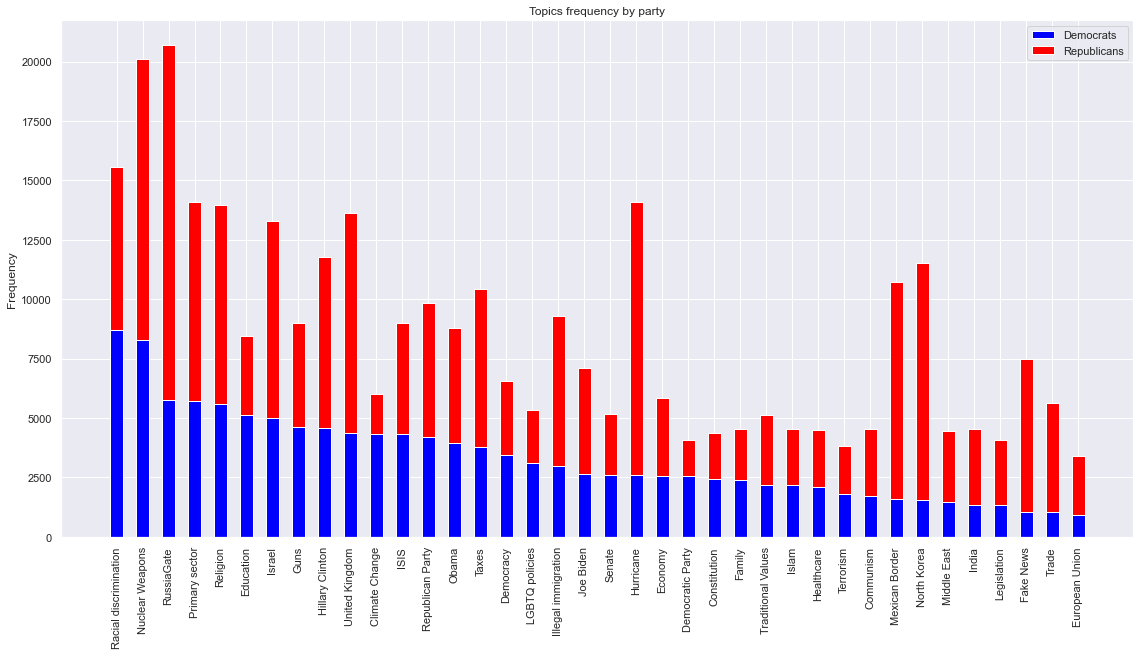

In [21]:
plt.figure(figsize=(10, 10))
categories_dem = df_quotes_topics.loc[df_quotes_topics['party']== DEMOCRATIC_PARTY_ID]['cluster'].value_counts().index
categories_rep = df_quotes_topics.loc[df_quotes_topics['party']== REPUBLICAN_PARTY_ID]['cluster'].value_counts().index
dem_values = df_quotes_topics.loc[df_quotes_topics['party']== DEMOCRATIC_PARTY_ID]['cluster'].value_counts().values
rep_values = df_quotes_topics.loc[df_quotes_topics['party']== REPUBLICAN_PARTY_ID]['cluster'].value_counts().values

bottom_values = np.zeros(categories_dem.size)
for i in range(categories_dem.size):
    categories_rep_list = list(categories_rep)
    categories_dem_list = list(categories_dem)
    bottom_values[categories_rep_list.index(categories_dem_list[i])] = dem_values[i]
fig, ax = plt.subplots()
ax.bar(categories_dem, dem_values, width=0.5,  label='Democrats', color="blue")
ax.bar(categories_rep, rep_values, width=0.5, bottom=bottom_values, label='Republicans', color="red")

ax.set_ylabel('Frequency')
ax.set_title('Topics frequency by party')
ax.legend()
fig.set_size_inches(16, 8)
fig.tight_layout()

plt.xticks(rotation='vertical')
fig.show()

From the plot above we can see that the two parties have given different importance to
each topic. Let's see then what were the most popular topics of the two parties across years.

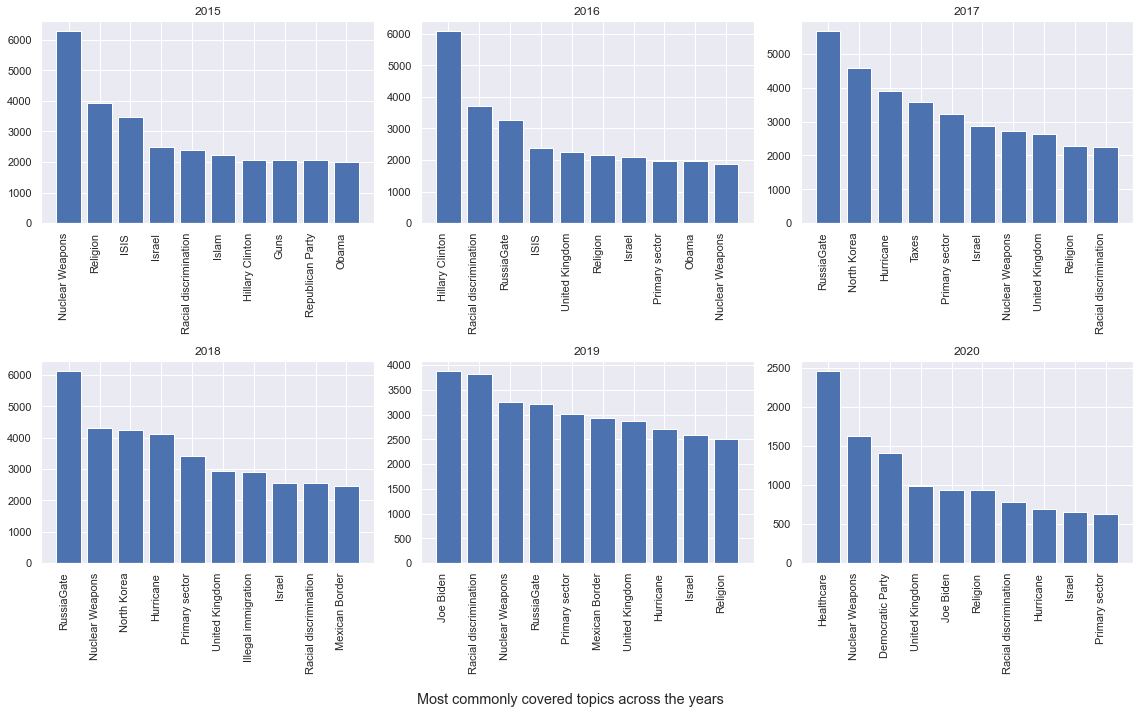

In [22]:
years = list(range(2015, 2021))

fig, axs = plt.subplots(2,3 , figsize = (15,10))
for i, ax in enumerate(axs.flat):
    mask = (df_quotes_topics['Date-Time'] <= f"{years[i]}-12-31") & (df_quotes_topics['Date-Time'] >= f"{years[i]}-01-01")
    most_common_topics = df_quotes_topics[mask]['cluster'].value_counts()[:10]
    ax.bar(list(most_common_topics.index), list(most_common_topics))
    ax.set_xticklabels(list(most_common_topics.index), rotation=90, ha='right')
    ax.set_title(years[i])

fig.supxlabel("Most commonly covered topics across the years")
fig.set_size_inches(16, 10)
fig.tight_layout()
fig.show()

Building a classifier based on topics

In [23]:
x = pd.get_dummies(df_quotes_topics['cluster']).to_numpy()
y = df_quotes_topics['party']
y[y == 29552] = 1
y[y == 29468] = 0
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
topic_classifier = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X_train, y_train)
topic_classifier.score(X_test, y_test)

0.642065475702696

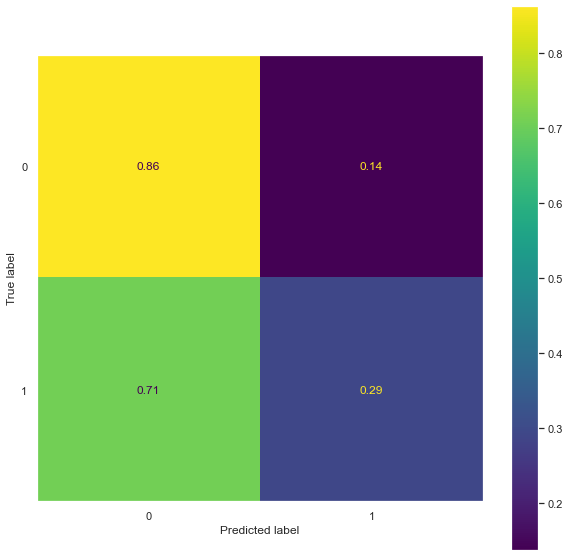

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(topic_classifier, X_test, y_test, normalize="true", ax=ax)
plt.grid(False)

Building a classifier based on topics and years

In [25]:
x = pd.get_dummies(df_quotes_topics['cluster']).to_numpy()
year_data = df_quotes_topics['Date-Time'].apply(lambda x: x.year).to_numpy()-2015
x = np.c_[x, year_data]
y = df_quotes_topics['party']
y[y == 29552] = 1
y[y == 29468] = 0
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
topic_classifier = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X_train, y_train)
topic_classifier.score(X_test, y_test)

0.7061480783413915

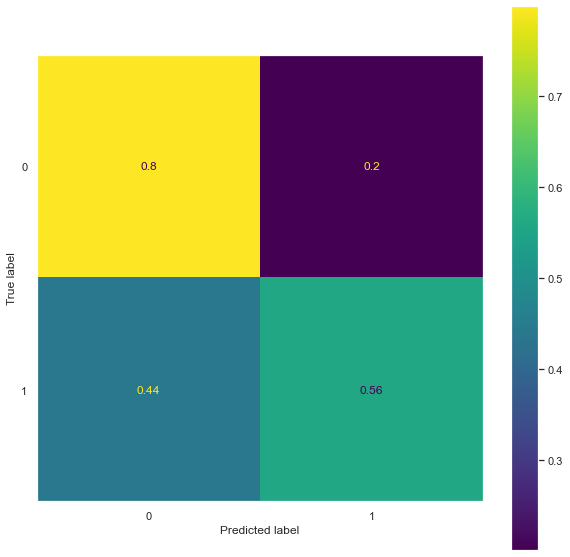

In [26]:
plot_confusion_matrix(topic_classifier, X_test, y_test, normalize="true")
plt.grid(False)

### 3. Sentiment Analysis

Having identified the topics often discussed by politicians, it is interesting to also identify their attitude towards those topics and identify whether it depends on the politicans' political affiliations.

Let's start with performing sentiment analysis: assigning a value in range $[-1, 1]$ to each quotation, where:
* $-1$ means highly **negative** sentiment
* $1$ means highly **positive** sentiment
* $0$ means no clear sentiment

To achieve that, we will make use of two sentiment analysis tools:
1. [`VADER-Sentiment`](https://github.com/cjhutto/vaderSentiment) library:  a rule-based sentiment analysis tool
2. *HuggingFace* [`transformers`](https://huggingface.co/docs/transformers/) library: a deep-learning-based NLP library providing access to several state-of-the-art models, often pre-trained on large datasets. In particular, we will use [this](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) *RoBERTa* model for pre-trained specifically for the sentiment analysis task.

Let's see examples of sentiment approximation for 5 random quotations from Donald Trump:

In [27]:
# construct the classifiers
device = 'cuda' if cuda.is_available() else 'cpu'
vader = SentimentIntensityAnalyzer()
roberta = Roberta(device) 

Downloading: 100%|██████████| 747/747 [00:00<00:00, 120kB/s]
Downloading: 100%|██████████| 878k/878k [00:00<00:00, 1.17MB/s] 
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 774kB/s]  
Downloading: 100%|██████████| 150/150 [00:00<00:00, 24.2kB/s]
Downloading: 100%|██████████| 476M/476M [02:39<00:00, 3.13MB/s] 


In [28]:
data = pd.read_pickle(
    "data/binary/us-politicians-with-clusters.pickle").reset_index(drop=True)

test_sentences = data[data["speaker"] == "Donald Trump"]["quotation"].sample(5).values.tolist()

for example in test_sentences:
  vader_res = vader.polarity_scores(example)['compound']
  roberta_res = roberta.predict_compound(example)
  print(f"""Sentence: {example}
    VADER-Sentiment score: {vader_res}
    ROBERTA-Sentiment score: {roberta_res}""")

Sentence: neo-Nazis, white nationalists.
    VADER-Sentiment score: 0.0
    ROBERTA-Sentiment score: -0.6697774529457092
Sentence: They're still making great cereal, right? I hope?
    VADER-Sentiment score: 0.8105
    ROBERTA-Sentiment score: 0.8715828657150269
Sentence: I don't want to get into it for a different reason, Joe, because if I do win, there has to be a certain amount of surprise, unpredictability. Let me be sort of a neutral guy, let's see what -- I'm going to give it a shot. It would be so great.
    VADER-Sentiment score: 0.9189
    ROBERTA-Sentiment score: 0.1654445081949234
Sentence: These recent acts are the acts of a coward and nothing more than terrorism, pure and simple. No one, regardless of political party or ideology, should ever have to go through what I went through,
    VADER-Sentiment score: 0.3335
    ROBERTA-Sentiment score: -0.966288149356842
Sentence: And then you had a whistleblower come out. So that hurt. That was not exactly positive,
    VADER-Senti

Seems quite accurate. Now, let's move on to predicting sentiment for all the quotations in the dataset, and analyze the sentiment distribution (I) for all speakers together (II) for republicans and democrats separately.

In [31]:
predict_sentiment = False
if predict_sentiment:
    # Note: this cell takes forever to run and was executed in an external environment in a cloud instance. Proceed to the next step to directly load the precomputed sentiment.
    tqdm.pandas()

    # predict vader sentiment for the whole dataset
    data["vader_sentiment"] = data["quotation"].progress_apply(lambda x: vader.polarity_scores(x)["compound"])

    # predict roberta sentiment for the whole dataset
    trimmed_quotes = data["quotation"].apply(lambda x: x[:200])
    predictions = roberta.batch_and_predict(trimmed_quotes.tolist(), 64, "compound")
    data["roberta_sentiment"] = pd.Series(predictions.tolist())

    # note: no 
    data.to_pickle("data/binary/clusters-and-sentiment.pickle")

In [32]:
data = pd.read_pickle("data/binary/clusters-and-sentiment.pickle")
data.sample(5)

,speaker_id,quote_id,quotation,speaker,party,Date-Time,cluster,vader_sentiment,roberta_sentiment
475773,22686,2017-02-18-023889,"It has to be much easier to manufacture in our country and much harder to leave. I don't want companies leaving our country. Making their product, selling it back, no tax, no nothing, firing everybody in our country,",Donald Trump,29468,2017-02-18,-1,0.0771,-0.321860
805092,22686,2019-01-31-066968,"Let's just call them WALLS from now on, and stop playing political games! A WALL is a WALL!",Donald Trump,29468,2019-01-31,-1,-0.2462,-0.468926
11365,76,2015-11-14-042302,"Once again, we've seen an outrageous attempt to terrorize innocent civilians. This is an attack not just on Paris, it's an attack not just on the people of France, but this is an attack on all of humanity and the universal values that we share. We stand prepared and ready to provide whatever assistance that the government and the people of France need to respond. France is our oldest ally. The French people have stood shoulder to shoulder with the United States time and again. And we want to be very clear that we stand together with them in the fight against terrorism and extremism.",Barack Obama,29552,2015-11-14,-1,-0.2641,-0.967776
262289,22686,2016-09-27-144066,When You Try To Act Holier-Than-Thou It Doesn't Work,Donald Trump,29468,2016-09-27,-1,0.0000,-0.660596
1430416,212648,2018-06-07-034617,"I don't believe her. I don't know, sue me Stormy, I don't believe you.",Rudy Giuliani,29468,2018-06-07,509,0.0000,-0.870238


In [33]:
def plot_sentiment_distribution(datasets, columns, config):
    colors = ["#000000","#0027FF","#900C3F","#ff6db6","#ffb6db","#490092","#006ddb","#b66dff","#6db6ff","#b6dbff","#920000","#924900","#db6d00","#24ff24","#ffff6d"]
    means = [data[columns].mean(axis=0).tolist() for data in datasets]
    stds = [data[columns].std(axis=0).tolist() for data in datasets]
    subtitles = config["subtitles"]

    fig, axs = plt.subplots(len(datasets), len(columns), sharey = "all", squeeze=False)
    for i in range(len(datasets)):
        for j in range(len(columns)):
            ax = axs[i][j]
            data = datasets[i][columns[j]]
            mean = means[i][j]
            std = stds[i][j]
            color = colors[i]
            subtitle = subtitles[i]
            ax.hist(data.values, color = color, bins=25, density=True, alpha=0.7)
            ax.axvline(mean - std, linestyle = '--', color = "red", label = f"-std: {np.round(mean - std, 3)}")
            ax.axvline(mean + std, linestyle = '--', color = "red", label = f"+std: {np.round(mean + std, 3)}")
            ax.axvline(mean, color = 'red', lw = 3, label = f"mean: {np.round(mean, 3)}")
            ax.set_title(subtitle)
            ax.legend()

    fig.supxlabel(config["xlabel"])
    fig.supylabel(config["ylabel"])
    fig.suptitle(config["title"])
    fig.set_size_inches(10, 12)
    fig.tight_layout()
    fig.show()

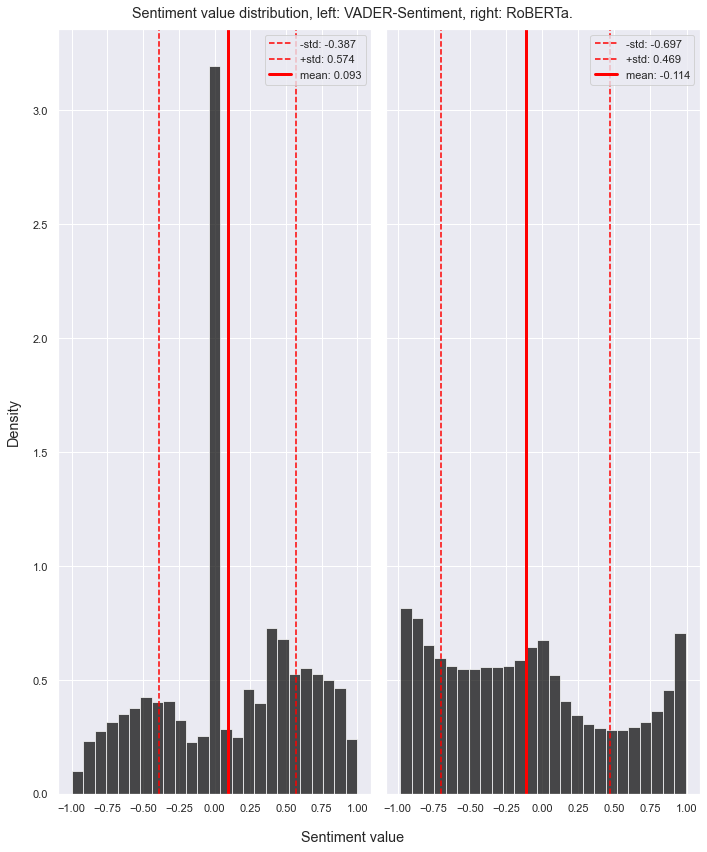

In [34]:
config = {
    "title": "Sentiment value distribution, left: VADER-Sentiment, right: RoBERTa.",
    "xlabel": "Sentiment value",
    "ylabel": "Density",
    "subtitles": [""]
}

columns = ["vader_sentiment", "roberta_sentiment"]
plot_sentiment_distribution([data], columns, config)

TODO: Add some discussion for the plots

In [35]:
def plot_party_sentiment_comparison(parties, columns, config):
    colors = ["#0027FF","#900C3F","#ff6db6","#ffb6db","#490092","#006ddb","#b66dff","#6db6ff","#b6dbff","#920000","#924900","#db6d00","#24ff24","#ffff6d"]
    subtitles = config["subtitles"]

    fig, axs = plt.subplots(1, len(columns), sharey = "all")
    for ax, column in zip(axs, columns):
        for party, subtitle, color in zip(parties, subtitles, colors):
            data = party[column]
            data = data[data != 0]
            mean = data.mean()
            ax.hist(data.values, color = color, bins=25, density=True, alpha=0.7)
            ax.axvline(mean, color = color, lw = 3, label = f"{subtitle} mean: {np.round(mean, 3)}")
        ax.legend()
           

    fig.supxlabel(config["xlabel"])
    fig.supylabel(config["ylabel"])
    fig.suptitle(config["title"])
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    fig.show()

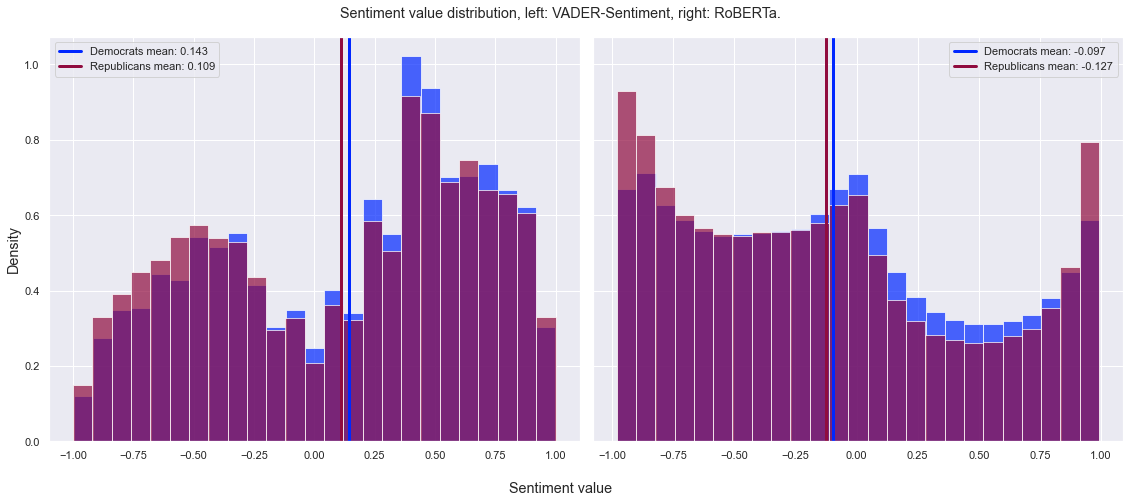

In [36]:
config = {
    "title": "Sentiment value distribution, left: VADER-Sentiment, right: RoBERTa.",
    "xlabel": "Sentiment value",
    "ylabel": "Density",
    "subtitles": ["Democrats", "Republicans"]
}

columns = ["vader_sentiment", "roberta_sentiment"]
parties = divide_by_party(data)[1:]
plot_party_sentiment_comparison(parties, columns, config)

    We can see that the distributions are quite similar: in both cases most of the quotations have no strong sentiment, causing a significant peak around zero. However, the results not totally identical for both parties: on average the Democrats' quotations have a slightly more positive sentiment than those of the Republicans. Let's see if it is statistically significant:

In [37]:
_, democrats, republicans = divide_by_party(data)
print("t-test result for comparing Roberta sentiment between parties: ", ttest_ind(democrats['vader_sentiment'], republicans['vader_sentiment']))
print("t-test result for comparing Roberta sentiment between parties: ", ttest_ind(democrats['roberta_sentiment'], republicans['roberta_sentiment']))

t-test result for comparing Roberta sentiment between parties:  Ttest_indResult(statistic=33.84436165023326, pvalue=5.360467957219275e-251)
t-test result for comparing Roberta sentiment between parties:  Ttest_indResult(statistic=32.5912356485957, pvalue=6.478026353846836e-233)


The test confirms that there is a statistically significant difference between the sentiment distributions for the two parties. To make it more visible, let's look at the plots again, now plotting them both on one graph and excluding the zero-sentiment values:

#### Sentiment per topic
Now, after analyzing the global sentiment distribution, let's look closer at sentiment towards specific topics. First of all, let's keep only the quotes belonging to a meaningful topic. Then, let's calculate average sentiment per party for each topic.

In [38]:
def sentiment_per_topic(df, topic_column, sentiment_column, topic):
    return df[df[topic_column] == topic][sentiment_column].mean()

def calculate_topic_sentiment(data, topic_column, sentiment_column):
    all_speakers, democrats, republicans = divide_by_party(data)
    all_sentiments = pd.Series([sentiment_per_topic(all_speakers, topic_column, sentiment_column, topic) for topic in TOPICS.values()])
    democratic_sentiments = pd.Series([sentiment_per_topic(democrats, topic_column, sentiment_column, topic) for topic in TOPICS.values()])
    republican_sentiments = pd.Series([sentiment_per_topic(republicans, topic_column, sentiment_column, topic) for topic in TOPICS.values()])
    topic_sentiment = pd.DataFrame(data = {"topic": TOPICS.values(), "Sentiment (all)": all_sentiments, "Sentiment (D)": democratic_sentiments, "Sentiment(R)": republican_sentiments})
    topic_sentiment = topic_sentiment.sort_values(by="Sentiment (all)")
    print(topic_sentiment)

In [39]:
data = pd.read_pickle("data/binary/clusters-and-sentiment.pickle")
data = filter_meaningful_topics(data, TOPICS)
print("Vader sentiment: ")
calculate_topic_sentiment(data, "cluster", "vader_sentiment")

Vader sentiment: 
                    topic  Sentiment (all)  Sentiment (D)  Sentiment(R)
22              Terrorism        -0.570598      -0.561892     -0.578238
19              Fake News        -0.371516      -0.300537     -0.382958
21            Legislation        -0.224843      -0.134506     -0.269285
2   Racial discrimination        -0.217286      -0.194474     -0.246241
32                  Islam        -0.186491      -0.204096     -0.170387
14                   Guns        -0.176555      -0.248084     -0.101507
13                   ISIS        -0.108413      -0.082104     -0.132642
33             Healthcare        -0.070499      -0.099008     -0.045571
15    Illegal immigration        -0.031191       0.048784     -0.069127
1         Nuclear Weapons        -0.021939       0.028016     -0.056949
26              Democracy        -0.011886      -0.002662     -0.022110
9         Hillary Clinton        -0.007820       0.113138     -0.085417
35                 Family        -0.002152    

In [40]:
print("Roberta sentiment: ")
calculate_topic_sentiment(data, "cluster", "roberta_sentiment")

Roberta sentiment: 
                    topic  Sentiment (all)  Sentiment (D)  Sentiment(R)
19              Fake News        -0.707511      -0.686145     -0.710956
22              Terrorism        -0.512952      -0.515088     -0.511077
21            Legislation        -0.477051      -0.333658     -0.547593
32                  Islam        -0.474310      -0.511069     -0.440686
2   Racial discrimination        -0.473492      -0.470627     -0.477128
26              Democracy        -0.392547      -0.372658     -0.414592
13                   ISIS        -0.359268      -0.312931     -0.401943
9         Hillary Clinton        -0.357969      -0.160931     -0.484373
14                   Guns        -0.350911      -0.384175     -0.316010
0              RussiaGate        -0.350883      -0.394687     -0.333942
1         Nuclear Weapons        -0.289766      -0.239921     -0.324698
27         LGBTQ policies        -0.270690      -0.212733     -0.351405
18              Joe Biden        -0.248787  

### 4. Readability and Understandabilty Analysis
Let us continue the exploration of most common words used in these quotes per party and try to analyse differences in their vocabulary.

We split the DataFrame into two, one for Democrats and one for Republicans. We take a random sample of Republicans'
quotes, since they are significantly more than Democrats' quotes, in order to have the same amount of sentences analyzed.
This way the representations are clearer but the result doesn't change.

In [41]:
democrats = data[data['party'] == DEMOCRATIC_PARTY_ID]
republicans = data[data['party'] == REPUBLICAN_PARTY_ID].sample(
    democrats['quote_id'].count())


Let's examine if our sample from the two parties is balanced across time. To do so, let's plot the distribution of the number of quotes per party across time:

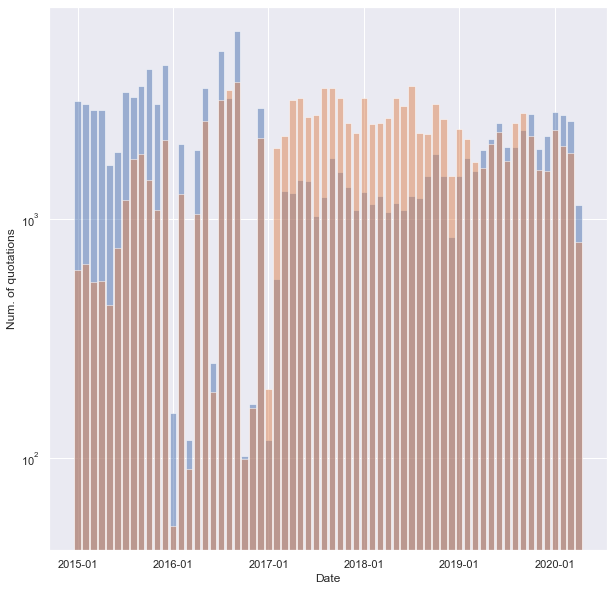

In [42]:
plot_across_time(democrats[["Date-Time", "quote_id"]].rename(columns={
                 'quote_id': 'count'}), republicans[["Date-Time", "quote_id"]].rename(columns={'quote_id': 'count'}))


We can see that, despite a few low values in 2016, the distribution is rather uniform, and the difference between the number of quotes of democrats and republicans across the year is not substantial enough to hinder our future analysis.

To get more useful observations from the words, we filter out simple stopwords, commonly used words of the English lang, expand abbreviations and stem the word tokens etc. This is similar to the pre-processing done in the word cloud section previously.

In [43]:
# get raw dataframe of all words used in the quotations dataset
# filter the words to remove stopwords, most common words, and also use a stemmer to expand abbreviations and normalise similar words
dem_words = filter_words(get_words(democrats))
rep_words = filter_words(get_words(republicans))

# we also remove single chars and lowercase everything
dem_words = [str.lower(w) for w in dem_words if len(w) > 1]
rep_words = [str.lower(w) for w in rep_words if len(w) > 1]

# filtering the words for unique words, as we are interested in frequencies of different words
dem_words_unq = pd.Series(dem_words).drop_duplicates()
rep_words_unq = pd.Series(rep_words).drop_duplicates()


We then reduce the lists of words to lists of unique words, as we are interested in the size and details of the vocabulary.

<Figure size 720x720 with 0 Axes>

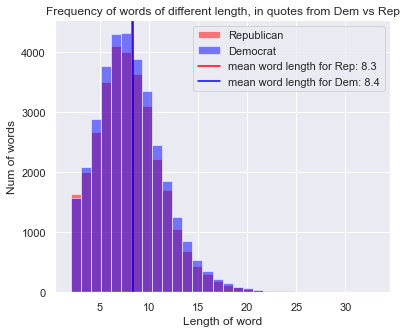

Ttest_indResult(statistic=-5.757003778519791, pvalue=8.599924016192213e-09)


In [44]:
# plotting the distribution of length of words in each party's vocab

plt.figure()
fig, ax = plt.subplots()

rep_words_len = rep_words_unq.apply(len).where(lambda l: l < 35)
dem_words_len = dem_words_unq.apply(len).where(lambda l: l < 35)

ax.hist(rep_words_len, bins=30, color='red', alpha=0.5, label='Republican')
ax.hist(dem_words_len, bins=30, color='blue', alpha=0.5, label='Democrat')
ax.axvline(rep_words_len.mean(), color='red',
           label=f"mean word length for Rep: {rep_words_len.mean():0.1f}")
ax.axvline(dem_words_len.mean(), color='blue',
           label=f"mean word length for Dem: {dem_words_len.mean():0.1f}")


ax.set_title(
    'Frequency of words of different length, in quotes from Dem vs Rep')
ax.set_ylabel('Num of words')
ax.set_xlabel('Length of word')
ax.legend()

fig.set_size_inches(6, 5)
plt.show()

print(ttest_ind(rep_words_len.dropna(), dem_words_len.dropna()))


Although slight, there exists a statistically significant difference between the avg length of the word present in the vocabulary of quotes from Republican vs Democratic speakers (as we see from the ttest p-value of ~0.0).

Filter the list to keep only words that were unique to quotes from Dem or Rep speakers. And visualize using word-clouds.

In [45]:
# find words which were only present in quotes from speakers of each party
dem_only_words = np.setdiff1d(
    dem_words_unq.to_numpy(), rep_words_unq.to_numpy(), assume_unique=True)
rep_only_words = np.setdiff1d(
    rep_words_unq.to_numpy(), dem_words_unq.to_numpy(), assume_unique=True)

dem_only_words = pd.Series(dem_only_words)
rep_only_words = pd.Series(rep_only_words)

dem_only_words.to_pickle('data/binary/dem_only_words.pickle')
rep_only_words.to_pickle('data/binary/rep_only_words.pickle')

In [46]:
# read from pickle if already present / can skip above block during dev
dem_only_words = pd.read_pickle('data/binary/dem_only_words.pickle')
rep_only_words = pd.read_pickle('data/binary/rep_only_words.pickle')

<Figure size 720x720 with 0 Axes>

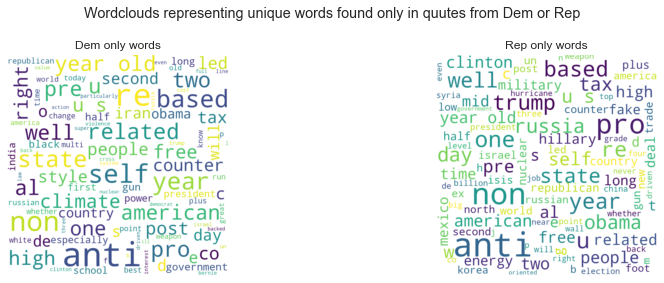

In [47]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Wordclouds representing unique words found only in quutes from Dem or Rep")
fig.set_size_inches(14, 4)

ax1.set_title('Dem only words')
ax1.imshow(make_wordcloud(dem_only_words), interpolation="bilinear")
ax1.axis('off')

ax2.set_title('Rep only words')
ax2.imshow(make_wordcloud(rep_only_words), interpolation="bilinear")
ax2.axis('off')

fig.tight_layout()
plt.show()


To generate more usefull insights from this vocab data we cluster the words obtained here into sets of synonyms, for easier manual labelling.

In [48]:
from nltk.corpus import wordnet
from nltk import download
download('wordnet', quiet=True)

# cluster the words into sets, based on synonym info from nltk.corpus.wordnet
def cluster(words):
    clusters = {}

    while(len(words) != 0):
        word = words.pop()

        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() in words:
                    if word in clusters:
                        clusters[word].append(lemma.name())
                    else:
                        clusters[word] = [word, lemma.name()]
                    words.remove(lemma.name())

    return clusters

In [49]:
# cluster the vocab into sets of similar words
# sort the clusters based on number of words present in them
dem_only_words_clustered = sorted(cluster(dem_only_words.tolist()).values(), key=len, reverse=True)
rep_only_words_clustered = sorted(cluster(rep_only_words.tolist()).values(), key=len, reverse=True)

# add to dataframe for easry handling and printing
dem_vocab_df = pd.DataFrame({'dem_words':dem_only_words_clustered})
rep_vocab_df = pd.DataFrame({'rep_words': rep_only_words_clustered})

vocabDf = pd.concat([dem_vocab_df, rep_vocab_df], axis=1)

vocabDf.head(20)

,dem_words,rep_words
0,"[flutter, flicker, commotion, flap, dart]","[chokes, fret, strangle, decease, perish, throttle]"
1,"[casted, wander, redact, barf, honk]","[backsides, arse, bum, keister, stern]"
2,"[bluest, gloomy, juicy, spicy, dingy]","[glamourise, romanticize, romanticise, glamorize]"
3,"[shrunken, flinch, funk, wince, withered]","[rouse, agitate, awaken, arouse]"
4,"[hooked, overcharge, soak, surcharge]","[peed, piss, pee, wee]"
5,"[heave, puff, warp, gag]","[embellishes, embellish, dramatise, adorn]"
6,"[forks, fork, crotch, pitchfork]","[stinking, stink, fetid, smelly]"
7,"[doughnuts, doughnut, donut, sinker]","[gonzo, eccentric, freakish, flaky]"
8,"[loot, pillage, clams, ransack]","[swashbuckler, madcap, hothead, lunatic]"
9,"[wringing, wring, wrench, rack]","[gushes, gush, spurt]"


#### Readability Analysis
Here we conduct a readability analysis on our dataset of quotes. We load the data and use the following measures of readability to create new columns:
- Flesch reading ease: in the Flesch reading-ease test, higher scores indicate material that is easier to read;
lower numbers mark passages that are more difficult to read.
- Dale Chall readability score: different from other tests, since it uses a lookup table of the most commonly used 3000 English words. It returns the grade level necessary to understand the sentence. Hence, the higher the score, the higher is the difficulty.
- Text Standard: based upon a combination of all the library's tests, returns the estimated school grade level required to understand the text.
- Reading time: returns the reading time of the given text. Assumes 14.69ms per character.

In [50]:
import textstat as ts

# we use the textstat library to calculate the scores for each quotation
if not os.path.exists("data/binary/us-politicians-complexity.pickle"):
    data['flesch_reading_ease'] = data['quotation'].apply(
        lambda x: ts.flesch_reading_ease(x))

    data['dale_chall_readability_score'] = data['quotation'].apply(
        lambda x: ts.dale_chall_readability_score_v2(x))

    data['text_standard'] = data['quotation'].apply(
        lambda x: ts.text_standard(x, True))

    data['reading_time'] = data['quotation'].apply(
        lambda x: ts.reading_time(x))
    # save to pickle
    data.to_pickle("data/binary/us-politicians-complexity.pickle")
else:
    PICKLE_PATH = "data/binary/us-politicians-complexity.pickle"
    data = pd.read_pickle(PICKLE_PATH)

readability_features = ['flesch_reading_ease',
                        'dale_chall_readability_score', 'text_standard', 'reading_time']

data.head()

# split into democratic and republican dataset and sample to be of equal size
democrats = data[data['party'] == DEMOCRATIC_PARTY_ID]
republicans = data[data['party'] == REPUBLICAN_PARTY_ID].sample(democrats['quote_id'].count())


We plot the difference between the length of quotes, to confirm a similar distribution, as the metrics we calculated are influenced by it.

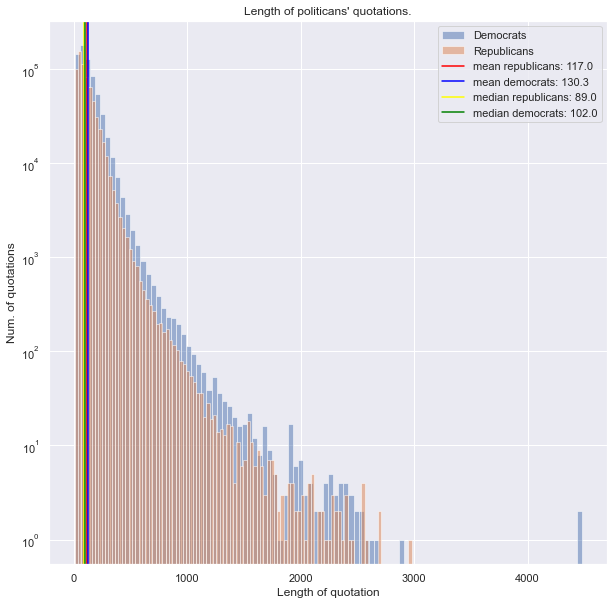

In [51]:
plot_length(democrats, republicans)


We see that the number of quotes decreases at a similar rate for both parties as the length of quotes increases, with a few outliers over the length 3000. We remove the outliers for better comparisons of the plots and to ensure more meaningful mean values.

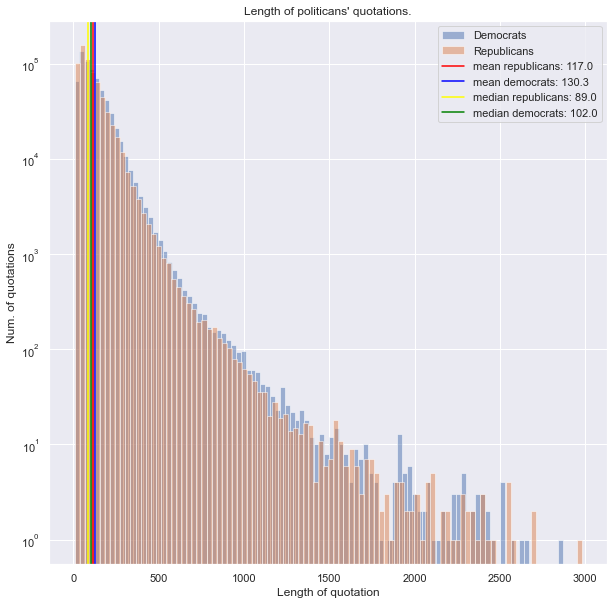

In [52]:
plot_length(democrats[democrats["quotation"].str.len() < 3000],
            republicans[republicans["quotation"].str.len() < 3000])


Plot the different metric scores across all speakers, from the two parties.

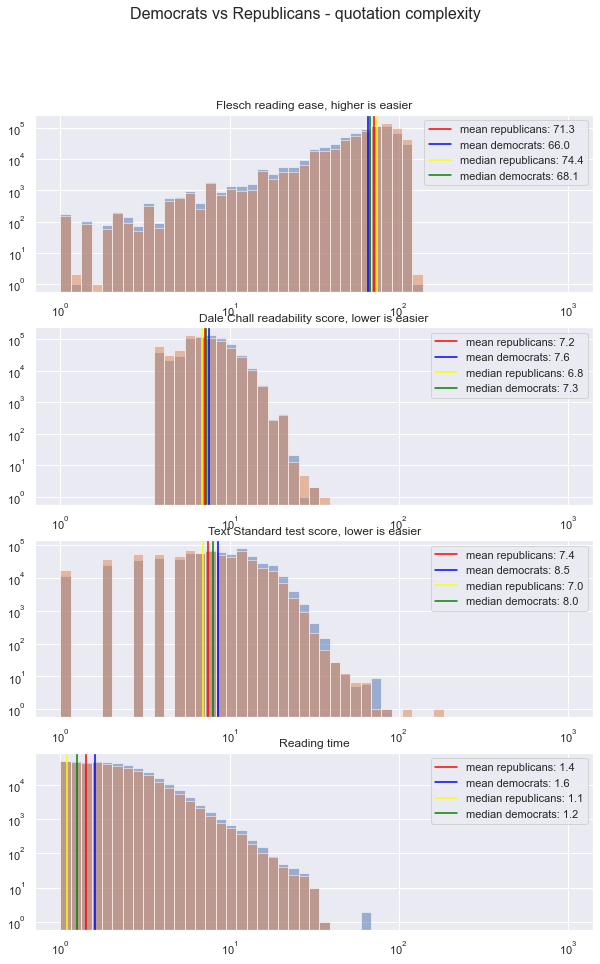

In [53]:
plot_metrics_scores(democrats, republicans,
                    "Democrats vs Republicans - quotation complexity")


Checking if there is a statistically significant difference in the values for the various metrics - 

In [54]:
for ft in readability_features:
    res = ttest_ind(democrats[ft], republicans[ft])
    print(f"{ft:<30} : {res}")


flesch_reading_ease            : Ttest_indResult(statistic=-122.11635884064957, pvalue=0.0)
dale_chall_readability_score   : Ttest_indResult(statistic=109.44290155785684, pvalue=0.0)
text_standard                  : Ttest_indResult(statistic=140.70807991319086, pvalue=0.0)
reading_time                   : Ttest_indResult(statistic=75.35423895837411, pvalue=0.0)


The p-values are lower than the 0.05 threshold, i.e. the metrics do not have the same expected value for each party. Therefore there are statistically significant differences.

We see that the democratic quotations on average have a higher grade score required for reading and understading the text on each of the four metrics. These features can therefore help us predict the party affilition of a politician given their quote.  

For some futher analysis, let us plot the metrics for the two most popular speakers from each party.
And also see if there are any variations over the years.

In [55]:
print(
    f"Most common Democratic speaker : {democrats['speaker'].value_counts()[:1]}")

print(
    f"Most common Republican speaker : {republicans['speaker'].value_counts()[:1]}")


Most common Democratic speaker : Barack Obama    156738
Name: speaker, dtype: int64
Most common Republican speaker : Donald Trump    510836
Name: speaker, dtype: int64


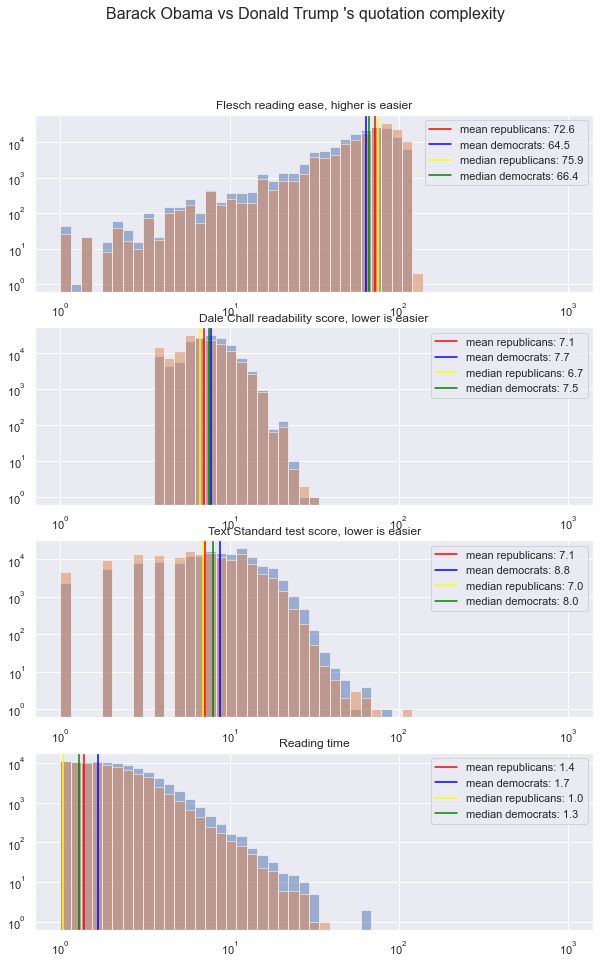

flesch_reading_ease            : Ttest_indResult(statistic=-88.52874871100435, pvalue=0.0)
dale_chall_readability_score   : Ttest_indResult(statistic=83.14380129828551, pvalue=0.0)
text_standard                  : Ttest_indResult(statistic=99.4888135338164, pvalue=0.0)
reading_time                   : Ttest_indResult(statistic=59.975716785762735, pvalue=0.0)


In [56]:
barack_obama = democrats[democrats['speaker'] == 'Barack Obama']
donald_trump = republicans[republicans['speaker'] == 'Donald Trump']

# again we take a random sample of equal number of quotes, for clearer visualizations
donald_trump = donald_trump.sample(barack_obama['quote_id'].count())

plot_metrics_scores(barack_obama, donald_trump,
                    "Barack Obama vs Donald Trump 's quotation complexity")

# and we check for statistical significance in the differece bw metric values
for ft in readability_features:
    res = ttest_ind(barack_obama[ft], donald_trump[ft])
    print(f"{ft:<30} : {res}")


The quotations of Barack Obama and Donald Trump show similar statistical differences in readability compared to their party's average. i.e The quotes from Democratic speakers on avg. require a higher grade for understandability.

We can also compare the difference in these metrics over the years.

<Figure size 720x720 with 0 Axes>

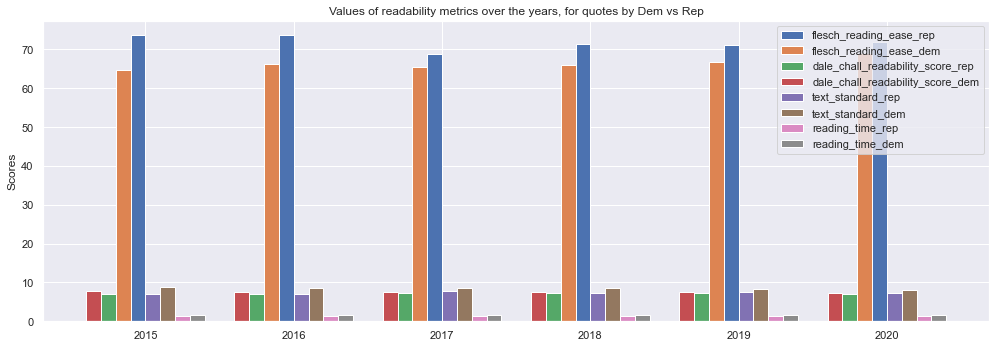

In [57]:
years = list(range(2015, 2021))

yearly_readability_data = {}
for ft in readability_features:
    yearly_readability_data[ft+'_rep'] = []
    yearly_readability_data[ft+'_dem'] = []

for year in years:
    year_df_rep = republicans[republicans['Date-Time'] <= f"{year}-12-31"]
    year_df_rep = year_df_rep[year_df_rep['Date-Time'] >= f"{year}-1-1"]

    year_df_dem = democrats[democrats['Date-Time'] <= f"{year}-12-31"]
    year_df_dem = year_df_dem[year_df_dem['Date-Time'] >= f"{year}-1-1"]

    for ft in readability_features:
        yearly_readability_data[ft+'_rep'].append(year_df_rep[ft].mean())
        yearly_readability_data[ft+'_dem'].append(year_df_dem[ft].mean())

plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(14, 5)

x = np.arange(len(years))
width = 0.1

for i, (ft, score) in enumerate(yearly_readability_data.items()):
    if i < (len(yearly_readability_data.keys()) / 2):
        x_loc = x - (width/2) - (i * width)
    else:
        i = i - len(yearly_readability_data.keys()) / 2
        x_loc = x + (width/2) + (i * width)

    ax.bar(x_loc, score, width, label=ft)

ax.set_ylabel('Scores')
ax.set_title(
    'Values of readability metrics over the years, for quotes by Dem vs Rep')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()


We see from the graph above that the difference in scores for the three metrics was the most pronounced in 2015, and the magnitude of the difference has shrunk slighly over the years. However, the democrats still consistently maintain a higher required grade for understanding the content in their quotes.



This was a simple and mostly superficial analysis of the readability metrics for quotes by speakers of both parties, however we already discovered statistically significant differences in the scores for these metrics between the two parties. And these differences are consistent between all four metrics we judged. i.e. Quotes from republican speakers have shown to be easier to understand and require a lower grade level.

These scores could thus be useful features for our affiliation predicting classifier.

In [58]:
# Classifier based on complexity scores
X = data[['flesch_reading_ease', 'dale_chall_readability_score', 'text_standard', 'reading_time']].to_numpy()
y = data['party'].to_numpy()
y[y == 29552] = 1
y[y == 29468] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
topic_classifier = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X_train, y_train)
print(f"Accuracy: {topic_classifier.score(X_test, y_test):.4f}")

Accuracy: 0.5961


### 5. Political Classifier

Here we try to better predict the party affiliations by considering all the sections we analyzed before: topics, sentiment, and language complexity. After training a regressor using the individual features, we'll train a linear model to see which amongst the three better allows us to predict the affiliation.

In [2]:
cluster_and_sentiment = pd.read_pickle("data/binary/clusters-and-sentiment.pickle")
complexity = pd.read_pickle("data/binary/us-politicians-complexity.pickle")
data = cluster_and_sentiment[['quote_id', 'vader_sentiment', 'roberta_sentiment', 'cluster']].merge(complexity, on='quote_id')
data.head()

,quote_id,vader_sentiment,roberta_sentiment,cluster,speaker_id,quotation,speaker,party,Date-Time,flesch_reading_ease,dale_chall_readability_score,text_standard,reading_time
0,2015-06-11-000090,0.0000,-0.102108,-1,1282411,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11,36.96,11.10,17.0,0.84
1,2015-08-11-090504,0.0000,0.448411,-1,1282411,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11,41.36,10.35,11.0,1.04
2,2015-10-27-125840,0.3102,-0.002347,-1,1282411,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27,34.43,10.64,24.0,6.14
3,2015-01-19-008025,-0.3400,-0.285690,-1,1282411,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19,25.80,11.73,16.0,1.73
4,2015-12-09-094134,0.9382,0.209529,-1,1282411,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09,0.76,11.33,0.0,4.39


In [4]:
def get_predictors(data):
    x_readability = data[['flesch_reading_ease', 'dale_chall_readability_score', 'text_standard', 'reading_time']].to_numpy()
    x_sentiment = data[['vader_sentiment', 'roberta_sentiment']].to_numpy()
    x_topics = np.c_[pd.get_dummies(data['cluster']).to_numpy(), data['Date-Time'].apply(lambda x: x.year).to_numpy()-2015]
    y = data['party'].to_numpy()
    y[y == 29552] = 1
    y[y == 29468] = 0
    pred_topics = MLPRegressor(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(x_topics, y).predict(x_topics)
    pred_readability = MLPRegressor(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(x_readability, y).predict(x_readability)
    pred_sentiment = MLPRegressor(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(x_sentiment, y).predict(x_sentiment)
    return np.c_[pred_topics, pred_sentiment, pred_readability]



In [21]:
X = get_predictors(data)
linear_model = sm.OLS(y, sm.add_constant(X)).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                 6.494e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:14:11   Log-Likelihood:            -1.0797e+06
No. Observations:             1650105   AIC:                         2.159e+06
Df Residuals:                 1650101   BIC:                         2.160e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8415      0.006   -150.665      0.0

For all the three predictors the p-value is less than our significance level (0.025), thus, for each predictor, we can reject the null hypothesis that it has no correlation with the outcome. All three predictors are statistically significant.

Now, let's try predicting the value in each year to see if the difference between the two parties has been getting bigger or smaller.

In [7]:
years = [i for i in range(2015, 2021)]
predictions = []
ys = []
for year in years:
    df = data[data['Date-Time'].apply(lambda x: x.year).to_numpy() == year]
    X = get_predictors(df)
    y = df['party'].to_numpy()
    y[y == 29552] = 1
    y[y == 29468] = 0
    pred = MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'logistic', solver = 'adam').fit(X, y).predict(X)
    predictions.append(pred)
    ys.append(y)



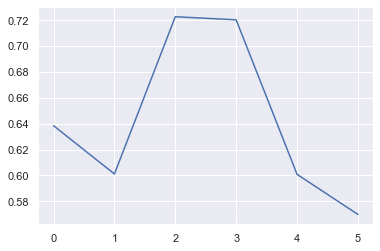

In [8]:
accuracies = [accuracy_score(ys[i], predictions[i]) for i in range(len(years))]
plt.plot(accuracies)
plt.show()